In [1]:

# 1 MOUNT GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive')

train_path = '/content/drive/MyDrive/train.csv'
test_path = '/content/drive/MyDrive/test.csv'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 2 LOAD DATA

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(train_df.shape, test_df.shape)
train_df.head()


Mounted at /content/drive
(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


EDA

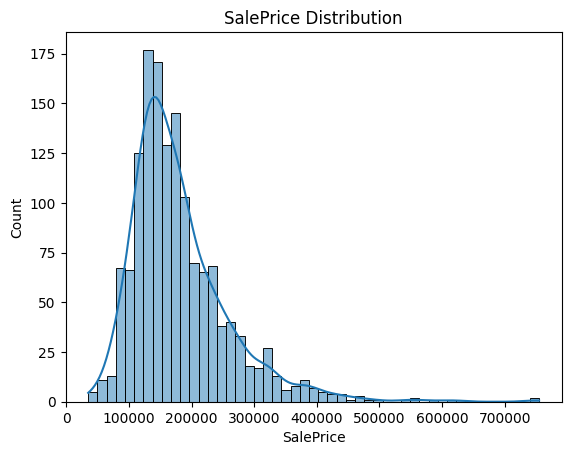

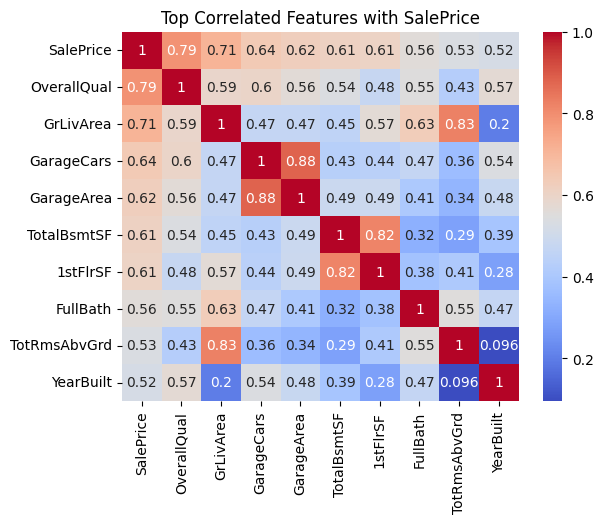

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
MasVnrType      0.597260
FireplaceQu     0.472603
LotFrontage     0.177397
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
dtype: float64


In [2]:

# SalePrice distribution
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('SalePrice Distribution')
plt.show()

# Correlation heatmap
corr = train_df.corr(numeric_only=True)
top_corr = corr['SalePrice'].abs().sort_values(ascending=False).head(10).index
sns.heatmap(train_df[top_corr].corr(), annot=True, cmap='coolwarm')
plt.title('Top Correlated Features with SalePrice')
plt.show()

# Check missing data
missing = train_df.isnull().mean().sort_values(ascending=False)
print(missing[missing > 0].head(10))


SalePrice vs Top Features (Scatter / Boxplots)

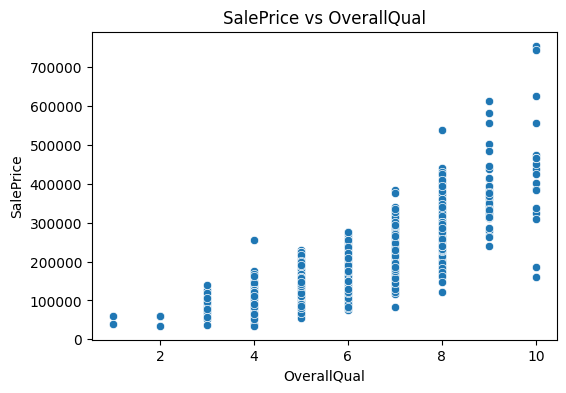

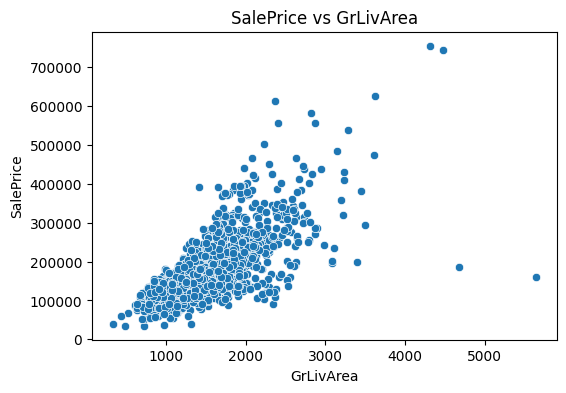

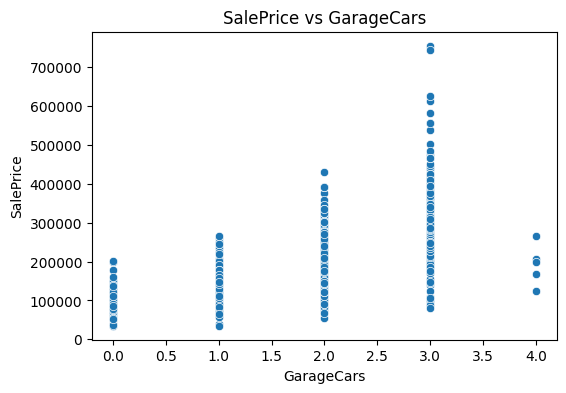

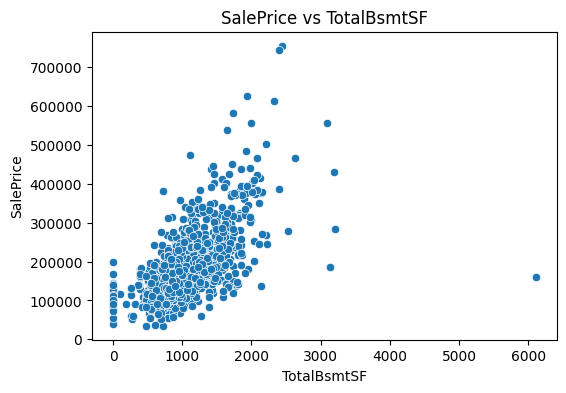

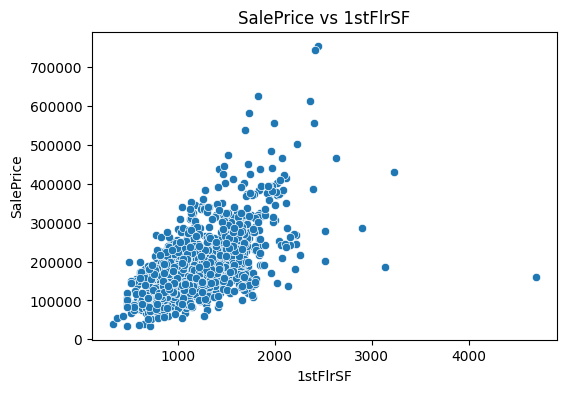

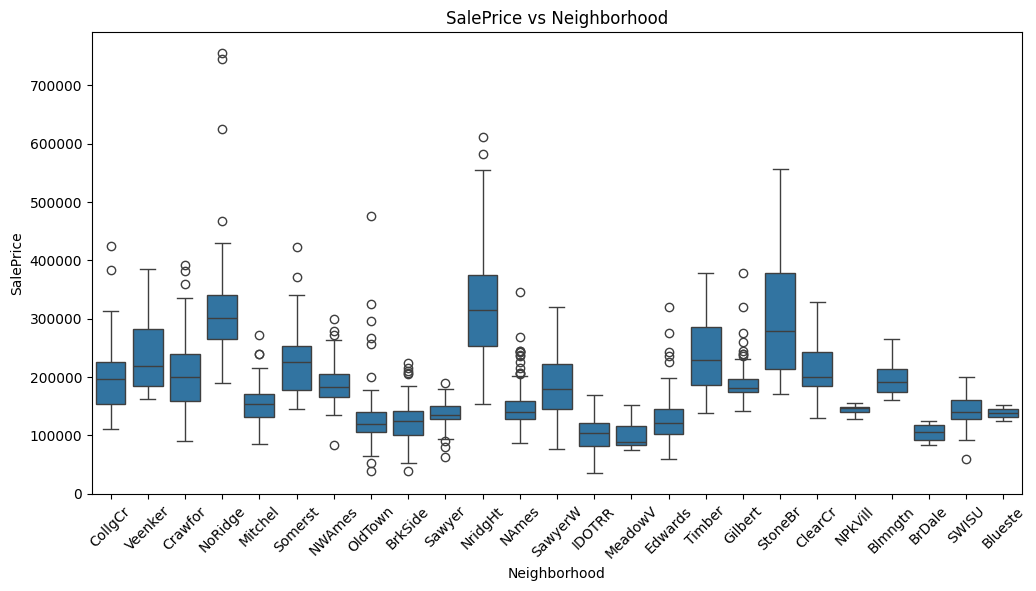

In [6]:
# Scatter plots for numeric top correlated features
import matplotlib.pyplot as plt

top_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']

for feature in top_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=train_df[feature], y=train_df['SalePrice'])
    plt.title(f'SalePrice vs {feature}')
    plt.show()


# Boxplots for categorical features strongly affecting price
# Example: Neighborhood
plt.figure(figsize=(12,6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_df)
plt.xticks(rotation=45)
plt.title('SalePrice vs Neighborhood')
plt.show()



Check Skewness / Kurtosis (for log transform decision)

In [7]:
print(f"Skewness: {train_df['SalePrice'].skew():.2f}")
print(f"Kurtosis: {train_df['SalePrice'].kurt():.2f}")


Skewness: 1.88
Kurtosis: 6.54


Pairplot

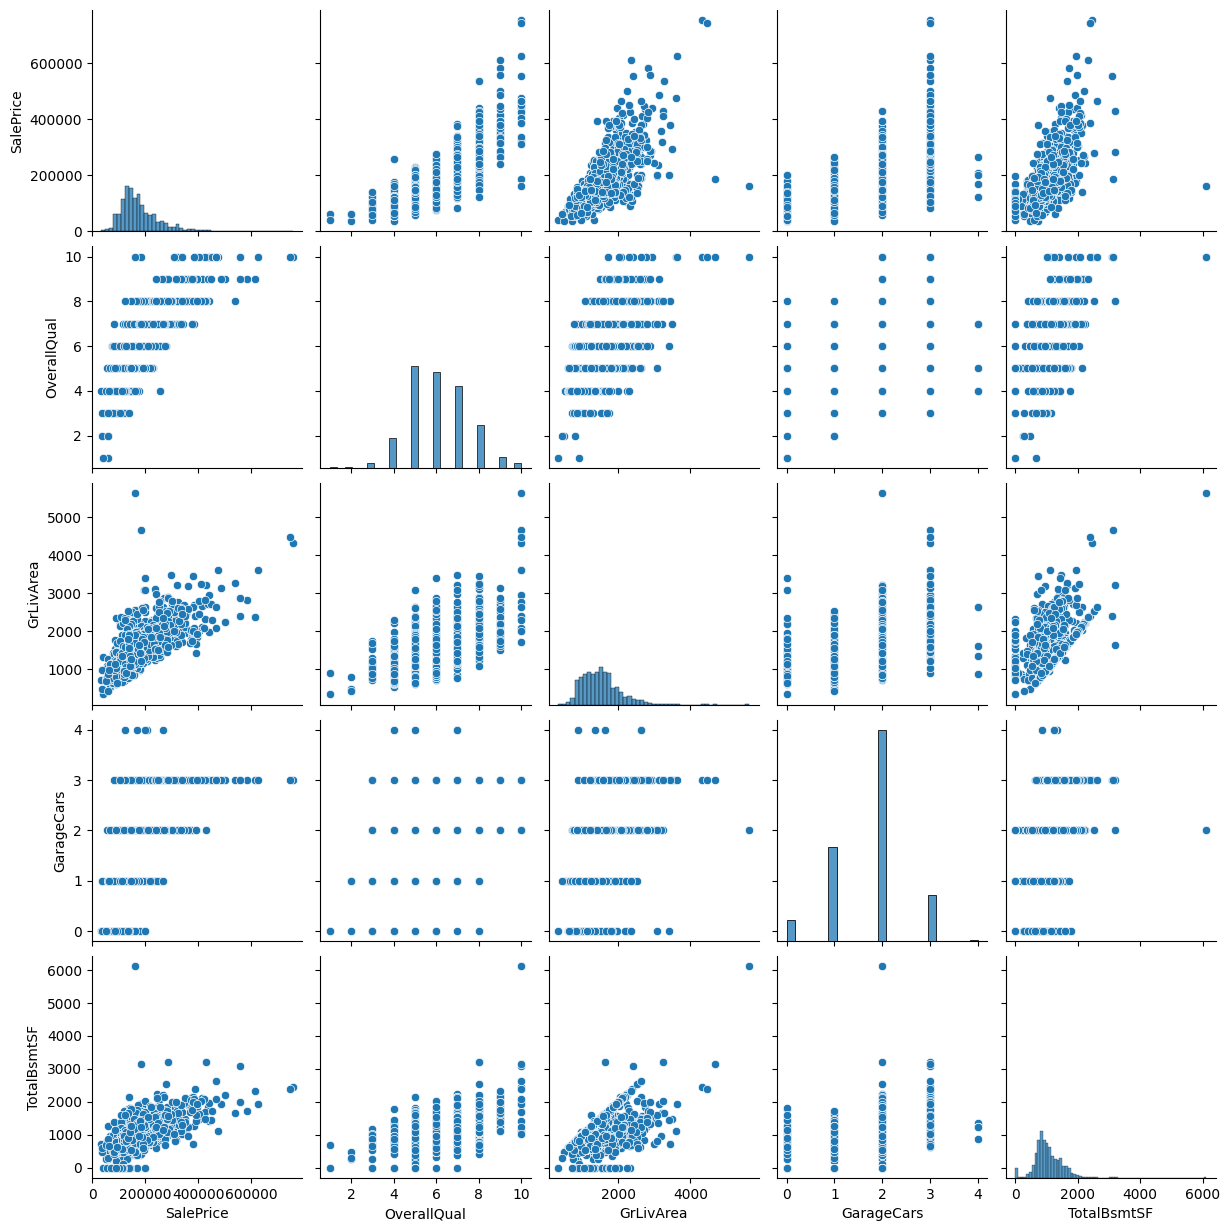

In [8]:
sns.pairplot(train_df[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']])
plt.show()


PREPROCESSING + FEATURE ENGINEERING

In [3]:

# Drop columns with too much missing data
drop_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

# Save ID
test_ids = test_df['Id']
train_df = train_df.drop(columns=['Id'])
test_df = test_df.drop(columns=['Id'])

# Fill missing values
def fill_missing(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    return df

train_df = fill_missing(train_df)
test_df = fill_missing(test_df)

# Separate target
y = train_df['SalePrice']
X = train_df.drop(columns=['SalePrice'])

# One-hot encode
X = pd.get_dummies(X)
X_test = pd.get_dummies(test_df)

# Align columns
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)


/tmp/ipython-input-3-768670899.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-3-768670899.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

 MODELING & EVALUATION

In [4]:

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=10000),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Scale numerical features for linear models
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

results = {}

for name, model in models.items():
    if name == 'RandomForest':
        scores = -cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    else:
        scores = -cross_val_score(model, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error')
    results[name] = scores.mean()
    print(f"{name} average RMSE: {scores.mean():.2f}")


LinearRegression average RMSE: 33224.00
Ridge average RMSE: 33162.13


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.729e+10, tolerance: 7.592e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e+10, tolerance: 7.288e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.905e+10, tolerance: 6.990e

Lasso average RMSE: 33269.97
RandomForest average RMSE: 29894.82


on Test Dataset we are applying this random forest to do get prediction result

In [10]:
# For scaled models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

linreg = LinearRegression()
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.01, max_iter=10000)
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit models
linreg.fit(X_scaled, y)
ridge.fit(X_scaled, y)
lasso.fit(X_scaled, y)
rf.fit(X, y)
# Predict
linreg_preds = linreg.predict(X_test_scaled)
ridge_preds = ridge.predict(X_test_scaled)
lasso_preds = lasso.predict(X_test_scaled)
rf_preds = rf.predict(X_test)

import pandas as pd

# Example: Save Random Forest predictions
output = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': rf_preds
})

output.to_excel('/content/drive/MyDrive/house_price_predictions_rf.xlsx', index=False)
print("Saved Random Forest predictions!")




/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.531e+10, tolerance: 9.208e+08
  model = cd_fast.enet_coordinate_descent(


Saved Random Forest predictions!
